In [56]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import backend as K
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,24,40,40,74,84,94,110,110,120,170
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,76,89,104,123,146,174,186,197,212,223
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,139,201,230,264,302,367,409,454,511,584
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,88,113,133,164,188,224,267,308,334,370
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,3,3,3,4,4,5,7,7


In [3]:
df = df.groupby(['Country/Region']).sum().reset_index(level=['Country/Region'])
dates = df.columns[4:]

df = df.melt(id_vars=[ 'Country/Region', 'Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Confirmed')
df['Date'] =pd.to_datetime(df.Date)

df = df[df['Country/Region'] != 'China']
df_c = df

In [4]:
df_c.head()

,Country/Region,Lat,Long,Date,Confirmed
0,Afghanistan,33.0000,65.0000,2020-01-23,0
1,Albania,41.1533,20.1683,2020-01-23,0
2,Algeria,28.0339,1.6596,2020-01-23,0
3,Andorra,42.5063,1.5218,2020-01-23,0
4,Angola,-11.2027,17.8739,2020-01-23,0


In [5]:
df = df.groupby('Date')['Confirmed'].sum().reset_index()
df['Day num'] = np.arange(1, len(df)+1)
df.head()

,Date,Confirmed,Day num
0,2020-01-23,11,1
1,2020-01-24,21,2
2,2020-01-25,28,3
3,2020-01-26,43,4
4,2020-01-27,50,5


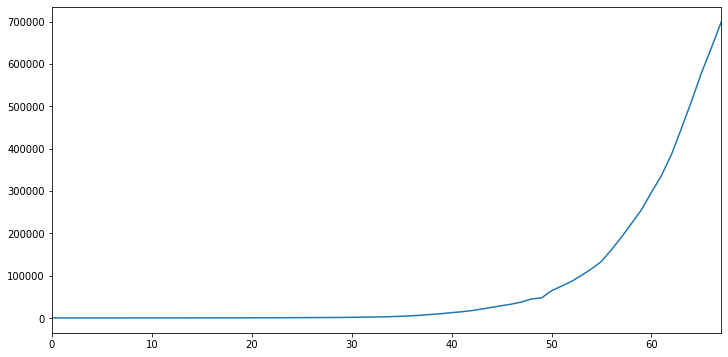

In [6]:
df['Confirmed'].plot(figsize=(12,6))

In [131]:
num_epochs = 100
batch_size = 32
split = 0.8
window = 14

In [132]:
training = split
total = df.shape[0]
train_index = int(total*training)

In [133]:
training_set = df[:train_index]

In [134]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = pd.DataFrame(training_set['Confirmed']).values

In [164]:
# training_set

In [136]:
# df

In [137]:

X_train = []
y_train = []
for i in range(window, train_index):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [138]:
# X_train

In [139]:
y_train

array([   207,    281,    306,    321,    408,    416,    462,    473,
          527,    617,    711,    824,    925,   1020,   1120,   1269,
         1571,   1936,   2320,   2652,   3222,   4146,   5184,   6655,
         8437,  10170,  12579,  14734,  17349,  21111,  25077,  28998,
        32730,  37733,  44954,  47420,  64260,  75124,  86451, 100541],
      dtype=int64)

In [140]:
testing_set = df[train_index:]
testing_set = pd.DataFrame(testing_set)
testing_set.head()

,Date,Confirmed,Day num
54,2020-03-17,116044,55
55,2020-03-18,133719,56
56,2020-03-19,161344,57
57,2020-03-20,190785,58
58,2020-03-21,223091,59


In [173]:
real_conf = testing_set['Confirmed'].values

In [174]:
test_set=testing_set['Confirmed']
test_set=pd.DataFrame(test_set)

In [175]:
inputs = df['Confirmed'][len(df) - len(testing_set) - window:].values
# print(inputs)
inputs = inputs.reshape(-1,1)
# print(inputs)
X_test = []
for i in range(window, window+(total-train_index)):
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [179]:
# inputs
# total

In [144]:
Y_test = pd.DataFrame(testing_set['Confirmed']).reset_index(drop=True).values

In [145]:
def root_mean_squared_logarithmic_error(y_true, y_pred):
        return K.sqrt(tf.keras.losses.MSLE(y_pred, y_true))

In [154]:
model = Sequential()

model.add(LSTM(units = 256, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# model.add(Dropout(0.2))

# model.add(LSTM(units = 128, return_sequences = True))
# model.add(Dropout(0.2))

# model.add(LSTM(units = 50, return_sequences = True))
# model.add(Dropout(0.2))

model.add(LSTM(units = 128))
# model.add(Dropout(0.2))

model.add(Dense(units = 256))

model.add(Dense(units = 1, activation="relu"))

model.compile(optimizer = 'adam', loss = root_mean_squared_logarithmic_error)

In [155]:
history = model.fit(X_train, y_train, epochs = num_epochs, batch_size = batch_size, validation_data = (X_test, Y_test))

Train on 40 samples, validate on 14 samples
Epoch 1/100
40/40 [==============================] - 1s 29ms/step - loss: 7.7710 - val_loss: 11.1975
Epoch 2/100
40/40 [==============================] - 0s 4ms/step - loss: 6.7157 - val_loss: 10.6237
Epoch 3/100
40/40 [==============================] - 0s 4ms/step - loss: 6.1721 - val_loss: 10.2210
Epoch 4/100
40/40 [==============================] - 0s 5ms/step - loss: 5.7921 - val_loss: 9.9192
Epoch 5/100
40/40 [==============================] - 0s 4ms/step - loss: 5.4990 - val_loss: 9.6723
Epoch 6/100
40/40 [==============================] - 0s 6ms/step - loss: 5.2547 - val_loss: 9.4568
Epoch 7/100
40/40 [==============================] - 0s 4ms/step - loss: 5.0455 - val_loss: 9.2763
Epoch 8/100
40/40 [==============================] - 0s 4ms/step - loss: 4.8672 - val_loss: 9.1206
Epoch 9/100
40/40 [==============================] - 0s 4ms/step - loss: 4.7135 - val_loss: 8.9811
Epoch 10/100
40/40 [==============================] - 0s 4ms/

40/40 [==============================] - 0s 4ms/step - loss: 2.2736 - val_loss: 6.5436
Epoch 83/100
40/40 [==============================] - 0s 4ms/step - loss: 2.2641 - val_loss: 6.5298
Epoch 84/100
40/40 [==============================] - 0s 4ms/step - loss: 2.2549 - val_loss: 6.5165
Epoch 85/100
40/40 [==============================] - 0s 4ms/step - loss: 2.2453 - val_loss: 6.5037
Epoch 86/100
40/40 [==============================] - 0s 4ms/step - loss: 2.2363 - val_loss: 6.4910
Epoch 87/100
40/40 [==============================] - 0s 4ms/step - loss: 2.2275 - val_loss: 6.4787
Epoch 88/100
40/40 [==============================] - 0s 4ms/step - loss: 2.2192 - val_loss: 6.4664
Epoch 89/100
40/40 [==============================] - 0s 5ms/step - loss: 2.2120 - val_loss: 6.4544
Epoch 90/100
40/40 [==============================] - 0s 4ms/step - loss: 2.2051 - val_loss: 6.4431
Epoch 91/100
40/40 [==============================] - 0s 4ms/step - loss: 2.1978 - val_loss: 6.4323
Epoch 92/100


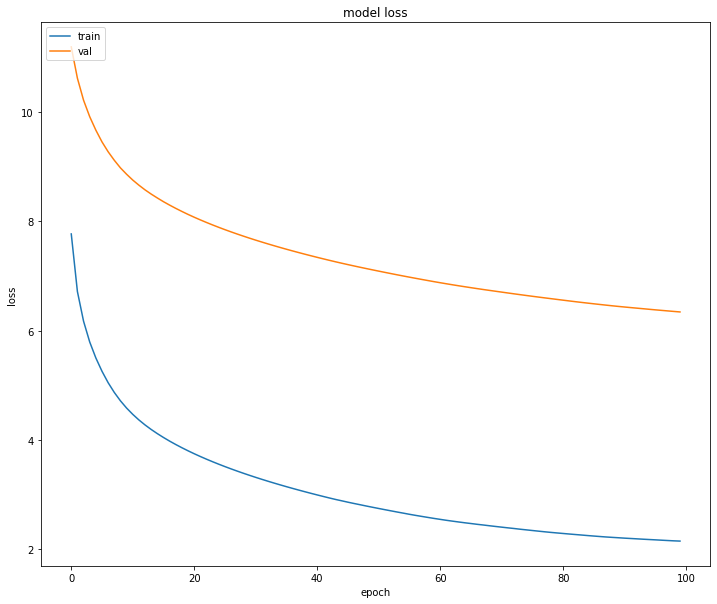

In [156]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [169]:
predicted_conf = model.predict(X_test)

In [170]:
# predicted_conf=pd.DataFrame(predicted_conf)

In [171]:
# predicted_conf
# X_test
# X_train
real_conf

,Confirmed
0,116044
1,133719
2,161344
3,190785
4,223091
5,255518
6,296737
7,336454
8,385992
9,447809


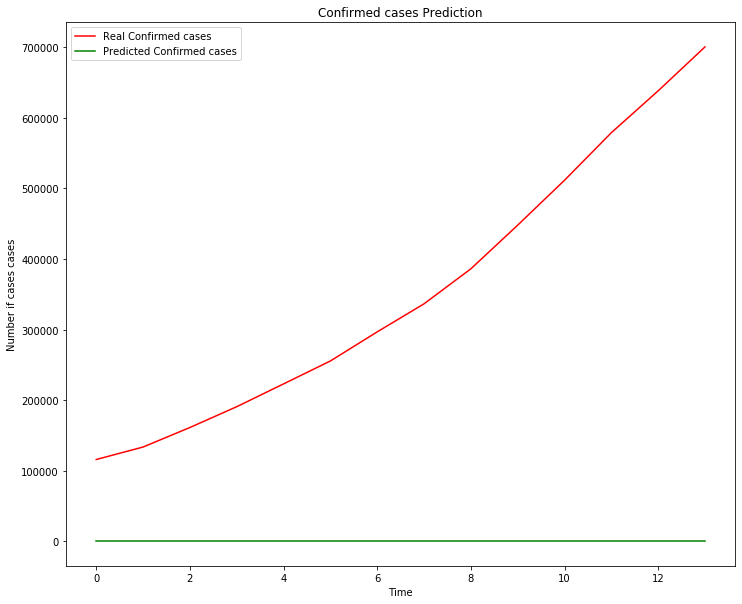

In [172]:
plt.rcParams['figure.figsize'] = [12, 10]
plt.plot(real_conf, color = 'red', label = 'Real Confirmed cases')
plt.plot(predicted_conf, color = 'green', label = 'Predicted Confirmed cases')
plt.title('Confirmed cases Prediction')
plt.xlabel('Time')
plt.ylabel('Number if cases cases')
plt.legend()
plt.show()